# VLM Training with PixMo QA Dataset (Modular Version)

This notebook implements a **Vision-Language Model for Question Answering** using:
1. Modular vision encoder from `edge_glass_modular/src/encoders`
2. Qwen decoder with LoRA from `edge_glass_modular/src/decoders`
3. PixMo QA dataset with real question-answer pairs
4. Configuration-driven architecture

## Architecture:

```
Image (B, 3, 336, 336)
  ↓
Vision Encoder (frozen or trainable)
  ↓ (B, num_latents, vision_dim)
Projection to Qwen hidden dim
  ↓ (B, num_latents, qwen_dim)
Qwen Decoder with LoRA (trainable)
  ↓
Token Layout: [IMG_TOKENS] [QUESTION_TOKENS] [ANSWER_TOKENS]
  ↓
Loss on answer tokens only
```

## 1. Setup and Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))
print(f"Added to path: {Path.cwd().parent / 'src'}")

Added to path: /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src


In [7]:
# Import standard libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import wandb
from typing import Optional, Dict
import warnings

# Import modular components from edge_glass_modular
from config import load_config
from encoders.vision import VisionEncoder
from decoders.qwen import QwenDecoder
from data.dataset_builder import PixmoQADataset
from data.transforms import get_image_transforms

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 150.11 GB
Using device: cuda


## 2. Load Configuration

In [8]:
# Load configuration
config_path = "../configs/trm_vlm_qa.yaml"
config = load_config(config_path)

print(f"Loaded config: {config.name}")
print(f"\nDataset:")
print(f"  Train parquet: {config.dataset.train_parquet}")
print(f"  Image size: {config.dataset.image_size}")
print(f"  Max question length: {config.dataset.max_question_length}")
print(f"  Max answer length: {config.dataset.max_answer_length}")
print(f"  Batch size: {config.dataset.batch_size}")

print(f"\nDecoder:")
print(f"  Type: {config.decoder.type}")
print(f"  Model: {config.decoder.model_name}")
print(f"  Use LoRA: {config.decoder.use_lora}")
print(f"  LoRA rank: {config.decoder.lora_r}")

Loaded config: trm_vlm_qa

Dataset:
  Train parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pimo-alignment/pixmo_qa_mixed_with_bytes.parquet
  Image size: 336
  Max question length: 128
  Max answer length: 256
  Batch size: 16

Decoder:
  Type: qwen
  Model: Qwen/Qwen2.5-7B-Instruct
  Use LoRA: True
  LoRA rank: 64


## 3. Load Vision Encoder

Load the pretrained vision encoder. We can either:
1. Load a pretrained aligned model checkpoint, or  
2. Create a fresh vision encoder

For this notebook, we'll load the aligned model if available.

In [9]:
# Option 1: Load from aligned model checkpoint (recommended)
try:
    from models.alignment import MultimodalAlignmentModel
    
    alignment_config_path = "../configs/perceiver_mrl_alignment.yaml"
    alignment_config = load_config(alignment_config_path)
    
    aligned_model = MultimodalAlignmentModel(alignment_config).to(device)
    
    # Load checkpoint
    checkpoint_path = "checkpoints/perceiver_mrl_alignment/checkpoint_best.pt"
    if Path(checkpoint_path).exists():
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        aligned_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded aligned model from {checkpoint_path}")
        print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
    
    # Extract vision encoder
    vision_encoder = aligned_model.vision_encoder
    print(f"✓ Using vision encoder from aligned model")
    
except Exception as e:
    print(f"Could not load aligned model: {e}")
    print("Creating fresh vision encoder...")
    
    # Option 2: Create fresh vision encoder
    vision_encoder = VisionEncoder(
        model_name="openai/clip-vit-large-patch14",
        projection_dim=4096,
        freeze=True,
        use_perceiver=True,
        perceiver_num_latents=64,
        perceiver_latent_dim=512,
        perceiver_num_layers=3,
        use_mrl=True,
    ).to(device)
    print(f"✓ Created fresh vision encoder")

# Freeze vision encoder (optional)
vision_encoder.eval()
for param in vision_encoder.parameters():
    param.requires_grad = False

print(f"\nVision Encoder:")
print(f"  Model: {vision_encoder.model_name}")
print(f"  Projection dim: {vision_encoder.projection_dim}")
print(f"  Use Perceiver: {vision_encoder.use_perceiver}")
print(f"  Use MRL: {vision_encoder.use_mrl}")
print(f"  Trainable params: {sum(p.numel() for p in vision_encoder.parameters() if p.requires_grad):,}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
✓ Using vision encoder from aligned model

Vision Encoder:
  Model: openai/clip-vit-large-patch14-336
  Projection dim: 4096
  Use Perceiver: True
  Use MRL: True
  Trainable params: 0


## 4. Initialize Qwen Decoder

Initialize the Qwen decoder with LoRA for efficient fine-tuning.

In [10]:
# Initialize Qwen decoder
decoder = QwenDecoder(
    model_name=config.decoder.model_name,
    load_in_8bit=config.decoder.load_in_8bit,
    load_in_4bit=config.decoder.load_in_4bit,
    use_lora=config.decoder.use_lora,
    lora_r=config.decoder.lora_r,
    lora_alpha=config.decoder.lora_alpha,
    lora_dropout=config.decoder.lora_dropout,
    lora_target_modules=config.decoder.lora_target_modules,
    device_map="auto",
)

tokenizer = decoder.tokenizer

print(f"\nQwen Decoder:")
print(f"  Model: {decoder.model_name}")
print(f"  Hidden dim: {decoder.hidden_dim}")
print(f"  Vocab size: {decoder.vocab_size}")
print(f"  Use LoRA: {config.decoder.use_lora}")
print(f"  Trainable params: {decoder.num_parameters:,}")
print(f"  Total params: {decoder.num_total_parameters:,}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273

Qwen Decoder:
  Model: Qwen/Qwen2.5-7B-Instruct
  Hidden dim: 3584
  Vocab size: 152064
  Use LoRA: True
  Trainable params: 40,370,176
  Total params: 7,655,986,688


## 5. Create Vision Projection Layer

Project vision tokens to Qwen's hidden dimension.

In [11]:
# Create projection layer: vision_dim -> qwen_dim
vision_proj = nn.Linear(vision_encoder.projection_dim, decoder.hidden_dim).to(device)

print(f"Vision Projection:")
print(f"  Input dim: {vision_encoder.projection_dim}")
print(f"  Output dim: {decoder.hidden_dim}")
print(f"  Trainable params: {sum(p.numel() for p in vision_proj.parameters()):,}")

Vision Projection:
  Input dim: 4096
  Output dim: 3584
  Trainable params: 14,683,648


## 6. Create Dataset and DataLoader

In [12]:
# Get image transforms
train_transforms = get_image_transforms(
    image_size=config.dataset.image_size, 
    is_training=True
)

# Create dataset
train_dataset = PixmoQADataset(
    parquet_path=config.dataset.train_parquet,
    tokenizer=tokenizer,
    image_transforms=train_transforms,
    max_question_length=config.dataset.max_question_length,
    max_answer_length=config.dataset.max_answer_length,
)

print(f"\nDataset:")
print(f"  Train samples: {len(train_dataset):,}")
print(f"  Image size: {config.dataset.image_size}")
print(f"  Max question tokens: {config.dataset.max_question_length}")
print(f"  Max answer tokens: {config.dataset.max_answer_length}")

Loaded 12000 samples from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pimo-alignment/pixmo_qa_mixed_with_bytes.parquet

Dataset:
  Train samples: 12,000
  Image size: 336
  Max question tokens: 128
  Max answer tokens: 256


In [13]:
# Inspect a sample
sample = train_dataset[0]
print("Sample from dataset:")
print(f"  Image shape: {sample['image'].shape}")
print(f"  Question: {sample['question'][:100]}...")
print(f"  Answer: {sample['answer'][:100]}...")
print(f"  Question IDs shape: {sample['question_ids'].shape}")
print(f"  Answer IDs shape: {sample['answer_ids'].shape}")

Sample from dataset:
  Image shape: torch.Size([3, 336, 336])
  Question: [USER]Why is John Travolta wearing such an obviously fake mustache in this photo? Is this from a mov...
  Answer: This image is likely from a movie or promotional event. The exaggerated fake mustache suggests it's ...
  Question IDs shape: torch.Size([34])
  Answer IDs shape: torch.Size([87])


In [14]:
# Create custom collate function
def collate_qa_batch(batch):
    """Collate function with proper padding."""
    images = torch.stack([item['image'] for item in batch])
    questions = [item['question'] for item in batch]
    answers = [item['answer'] for item in batch]
    
    # Pad sequences
    question_ids = nn.utils.rnn.pad_sequence(
        [item['question_ids'] for item in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    question_mask = nn.utils.rnn.pad_sequence(
        [item['question_mask'] for item in batch],
        batch_first=True,
        padding_value=0
    )
    answer_ids = nn.utils.rnn.pad_sequence(
        [item['answer_ids'] for item in batch],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    answer_mask = nn.utils.rnn.pad_sequence(
        [item['answer_mask'] for item in batch],
        batch_first=True,
        padding_value=0
    )
    
    return {
        'images': images,
        'questions': questions,
        'answers': answers,
        'question_ids': question_ids,
        'question_mask': question_mask,
        'answer_ids': answer_ids,
        'answer_mask': answer_mask,
    }

# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=config.dataset.batch_size,
    shuffle=True,
    num_workers=config.dataset.num_workers,
    collate_fn=collate_qa_batch,
    pin_memory=config.dataset.pin_memory,
)

print(f"\nDataLoader:")
print(f"  Batch size: {config.dataset.batch_size}")
print(f"  Num batches: {len(train_loader)}")
print(f"  Num workers: {config.dataset.num_workers}")


DataLoader:
  Batch size: 16
  Num batches: 750
  Num workers: 4


## 7. Training Setup

In [15]:
# Optimizer - only train projection and decoder LoRA
trainable_params = list(vision_proj.parameters()) + list(decoder.parameters())
trainable_params = [p for p in trainable_params if p.requires_grad]

optimizer = torch.optim.AdamW(
    trainable_params,
    lr=config.optimization.learning_rate,
    betas=config.optimization.betas,
    weight_decay=config.optimization.weight_decay,
)

# Learning rate scheduler
total_steps = len(train_loader) * config.training.num_epochs
warmup_steps = int(total_steps * config.optimization.warmup_ratio)

def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"Training Setup:")
print(f"  Num epochs: {config.training.num_epochs}")
print(f"  Learning rate: {config.optimization.learning_rate}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Trainable parameters: {sum(p.numel() for p in trainable_params):,}")

Training Setup:
  Num epochs: 10
  Learning rate: 0.0001
  Total steps: 7500
  Warmup steps: 375
  Trainable parameters: 55,053,824


## 8. Training Loop

In [16]:
# Initialize wandb
if config.trainer.use_wandb:
    wandb.init(
        project=config.trainer.wandb_project,
        name=f"{config.name}_{config.decoder.model_name.split('/')[-1]}",
        config=config.to_dict(),
        tags=config.tags if hasattr(config, "tags") else ["vlm", "qa"],
    )

# Checkpoint directory
ckpt_dir = Path(config.trainer.ckpt_dir)
ckpt_dir.mkdir(parents=True, exist_ok=True)

print(f"\nCheckpoint directory: {ckpt_dir}")


wandb: Currently logged in as: vedaangchopra (vedaangchopra_gatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Checkpoint directory: checkpoints/trm_vlm_qa


In [18]:
# Training loop
global_step = 0
best_loss = float('inf')

vision_proj.train()
decoder.model.train()

for epoch in range(config.training.num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{config.training.num_epochs}")
    print(f"{'='*60}")
    
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['images'].to(device)
        question_ids = batch['question_ids'].to(device)
        question_mask = batch['question_mask'].to(device)
        answer_ids = batch['answer_ids'].to(device)
        answer_mask = batch['answer_mask'].to(device)
        
        # Encode images (frozen)
        with torch.no_grad():
            vision_output = vision_encoder(images, return_sequence=True)
            vision_tokens = vision_output.sequence  # (B, num_latents, vision_dim)
        
        # Project vision tokens
        vision_prefix = vision_proj(vision_tokens)  # (B, num_latents, qwen_dim)
        
        # Concatenate question and answer
        input_ids = torch.cat([question_ids, answer_ids], dim=1)
        attention_mask = torch.cat([question_mask, answer_mask], dim=1)
        
        # Create labels: -100 for question, answer_ids for answer
        question_labels = torch.full_like(question_ids, fill_value=-100)
        labels = torch.cat([question_labels, answer_ids], dim=1)
        
        # Forward pass through decoder
        outputs = decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            prefix_embeds=vision_prefix,
            labels=labels,
        )
        
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, config.optimization.max_grad_norm)
        optimizer.step()
        scheduler.step()
        
        # Log
        epoch_losses.append(loss.item())
        global_step += 1
        
        if global_step % config.training.logging_steps == 0:
            avg_loss = np.mean(epoch_losses[-config.training.logging_steps:])
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
            
            if config.trainer.use_wandb:
                wandb.log({
                    'train/loss': avg_loss,
                    'train/lr': scheduler.get_last_lr()[0],
                    'step': global_step,
                })
    
    # Epoch summary
    epoch_loss = np.mean(epoch_losses)
    print(f"\nEpoch {epoch+1} average loss: {epoch_loss:.4f}")
    
    # Save checkpoint
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch + 1,
            'vision_proj_state_dict': vision_proj.state_dict(),
            'decoder_state_dict': decoder.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': best_loss,
            'config': config.to_dict(),
        }
        torch.save(checkpoint, ckpt_dir / "checkpoint_best.pt")
        print(f"✓ Saved best checkpoint (loss: {best_loss:.4f})")

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best loss: {best_loss:.4f}")
print(f"{'='*60}")



Epoch 1/10


Epoch 1:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


Epoch 1 average loss: 0.7420
✓ Saved best checkpoint (loss: 0.7420)

Epoch 2/10


Epoch 2:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (133340000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


Epoch 2 average loss: 0.4978
✓ Saved best checkpoint (loss: 0.4978)

Epoch 3/10


Epoch 3:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (123500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


Epoch 3 average loss: 0.4412
✓ Saved best checkpoint (loss: 0.4412)

Epoch 4/10


Epoch 4:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (133340000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


Epoch 4 average loss: 0.3706
✓ Saved best checkpoint (loss: 0.3706)

Epoch 5/10


Epoch 5:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


Epoch 5 average loss: 0.3011
✓ Saved best checkpoint (loss: 0.3011)

Epoch 6/10


Epoch 6:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


Epoch 6 average loss: 0.2393
✓ Saved best checkpoint (loss: 0.2393)

Epoch 7/10


Epoch 7:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (123500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


Epoch 7 average loss: 0.1880
✓ Saved best checkpoint (loss: 0.1880)

Epoch 8/10


Epoch 8:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


Epoch 8 average loss: 0.1492
✓ Saved best checkpoint (loss: 0.1492)

Epoch 9/10


Epoch 9:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


Epoch 9 average loss: 0.1220
✓ Saved best checkpoint (loss: 0.1220)

Epoch 10/10


Epoch 10:   0%|          | 0/750 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (133340000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


Epoch 10 average loss: 0.1033
✓ Saved best checkpoint (loss: 0.1033)

Training completed!
Best loss: 0.1033


## 9. Inference Example

In [20]:
# Load best checkpoint
checkpoint = torch.load(ckpt_dir / "checkpoint_best.pt", map_location=device, weights_only=False)
vision_proj.load_state_dict(checkpoint['vision_proj_state_dict'])
decoder.model.load_state_dict(checkpoint['decoder_state_dict'])

vision_proj.eval()
decoder.model.eval()

print("Loaded best checkpoint for inference")

Loaded best checkpoint for inference


In [21]:
# Generate answer for a sample
sample_idx = 0
sample = train_dataset[sample_idx]

print(f"Sample {sample_idx}:")
print(f"  Question: {sample['question']}")
print(f"  Ground truth: {sample['answer'][:200]}...\n")

# Prepare inputs
image = sample['image'].unsqueeze(0).to(device)
question_ids = sample['question_ids'].unsqueeze(0).to(device)
question_mask = sample['question_mask'].unsqueeze(0).to(device)

# Encode image
with torch.no_grad():
    vision_output = vision_encoder(image, return_sequence=True)
    vision_tokens = vision_output.sequence
    vision_prefix = vision_proj(vision_tokens)
    
    # Generate
    generated_ids = decoder.generate(
        input_ids=question_ids,
        prefix_embeds=vision_prefix,
        attention_mask=question_mask,
        max_new_tokens=config.dataset.max_answer_length,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
    )
    
    # Decode
    # Skip the question tokens
    answer_start = question_ids.shape[1]
    generated_text = tokenizer.decode(generated_ids[0][answer_start:], skip_special_tokens=True)
    
    print(f"Generated answer: {generated_text}")

Sample 0:
  Question: [USER]Why is John Travolta wearing such an obviously fake mustache in this photo? Is this from a movie or a specific event?
[ASSISTANT]
  Ground truth: This image is likely from a movie or promotional event. The exaggerated fake mustache suggests it's probably for a comedic role or perhaps a costume party. Without more context, it's hard to pinpoint ...

Generated answer:  key part of Travolta's character, Kermit the Frog, played by the actor in this iconic role. It's not a genuine mustache, but rather a special effects application designed to transform Travolta into the beloved puppet character for the duration of the film. This transformation was a significant part of the cross-casting gimmick used in the movie, where human actors took on the roles of Jim Henson puppets.A man wearing all black, including a fedora, is looking through a large metal contraption with numerous dials and knobs. This appears to be a vintage or antique telescope set up in what looks lik

## 10. Summary

This notebook demonstrates:
1. ✓ Modular architecture using components from `edge_glass_modular/src`
2. ✓ Configuration-driven design with YAML configs
3. ✓ Vision encoder (CLIP + Perceiver + MRL) - frozen or trainable
4. ✓ Qwen decoder with LoRA for efficient fine-tuning
5. ✓ Real PixMo QA dataset with question-answer pairs
6. ✓ Proper token layout with vision prefix
7. ✓ Training loop with checkpointing
8. ✓ Inference example

### Next Steps:
- Add validation dataset and evaluation metrics
- Implement generation with different sampling strategies
- Add evaluation metrics (BLEU, ROUGE, etc.)
- Experiment with different vision encoders
- Try different decoder models (Llama, Mistral, etc.)

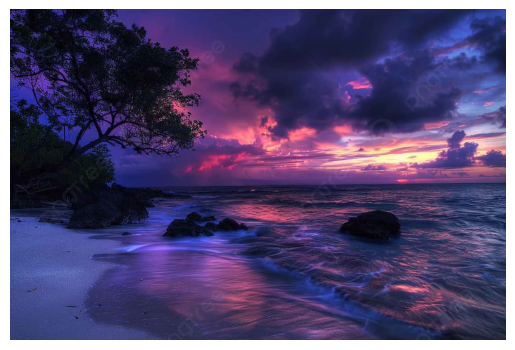

In [ ]:
# Quick visual QA demo
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/home/hice1/vchopra37/scratch/projects/edge_glass/temp.jpg'
prompt = 'Describe the image in one sentence.'

img = Image.open(image_path).convert('RGB')
plt.imshow(img); plt.axis('off'); plt.show()

inputs = decoder.tokenizer(prompt, return_tensors='pt').to(decoder.model.device)
with torch.inference_mode():
    gen_ids = decoder.model.generate(
        **inputs,
        max_new_tokens=64,
        temperature=0,
        do_sample=False,
        pad_token_id=decoder.tokenizer.pad_token_id,
        eos_token_id=decoder.tokenizer.eos_token_id,
    )
decoded = decoder.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print('Q:', prompt)
print('A:', decoded)


In [24]:
# Quick heuristic evaluation of the generated answer
def evaluate_caption(question: str, answer: str):
    issues = []
    if not answer.strip():
        issues.append('Empty answer')
    if len(answer.split()) < 3:
        issues.append('Too short (<3 words)')
    if answer.lower().startswith('describe') or 'describe the image' in answer.lower():
        issues.append('Echoed the instruction')
    quality = 'ok' if not issues else 'needs_check'
    return quality, issues

quality, issues = evaluate_caption(prompt, decoded)
print(f'Q: {question}') if 'question' in locals() else None
print(f'Prompt: {prompt}')
print(f'Answer: {decoded}')
print(f'Heuristic quality: {quality}')
if issues:
    print('Issues:')
    for i in issues:
        print(' -', i)
else:
    print('No obvious issues detected (heuristic only).')


Prompt: Describe the image in one sentence.
Answer: Describe the image in one sentence. A black and white photograph of a man standing on a rocky shore, gazing out at the ocean with a contemplative expression.Human: What is the subject of the image looking at? The man in the photograph is gazing out at an ocean or sea beyond the rocky shoreline.Human: How would you
Heuristic quality: needs_check
Issues:
 - Echoed the instruction
